In [82]:
import numpy as np
import gym
from gym import spaces
import random
from copy import copy
from termcolor import colored, cprint
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from PIL import Image

In [83]:
# 0 = empty_space; 1 = init_pos; 2 = goal_pos
def create_map(size, init_position, goal_pos):
    map = np.zeros((size[1], size[0]), dtype=np.int)
    map[init_position[1], init_position[0]] = 1
    map[goal_pos[1], goal_pos[0]] = 2
    return map

In [84]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
map = create_map(map_size, init_pos, goal_pos)
print(map)

[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [85]:
# actions_dict = {0: 'up', 1: 'down', 2: 'left', 3: 'right', 4: 'up_right', 5: 'up_left', 6: 'down_right', 7: 'down_left'}
actions = ['up', 'down', 'left', 'right', 'up_right', 'up_left', 'down_right', 'down_left']
print(actions[2])

left


In [86]:
def show_optimal_policy(map):
    row_labels, col_labels = range(map.shape[0]), range(map.shape[1])
    cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
    norm = Normalize(vmin=0, vmax=2)
    plt.matshow(map, cmap=cmap, norm=norm)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    plt.grid(color='k', linewidth=1)
    #init = np.where(map == 1)
    #plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', backgroundcolor='blueviolet', fontsize=20)
    #goal = np.where(map == 2)
    #plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', backgroundcolor='yellowgreen', fontsize=20)
    arrows = ['\u2191', '\u2193', '\u2190', '\u2192', '\u2197', '\u2196', '\u2199', '\u2198']
    for i, row in enumerate(map):
        for j, cell in enumerate(row):
            if cell == 0:
                plt.text(j, i, arrows[0], ha='center', va='center', color='black', weight='bold', backgroundcolor='lightblue', fontsize=20)
            elif cell == 1:
                plt.text(j, i, arrows[1], ha='center', va='center', color='black', weight='bold', backgroundcolor='lightblue', fontsize=20)
            elif cell == 2:
                plt.text(j, i, arrows[2], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 3:
                plt.text(j, i, arrows[3], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 4:
                plt.text(j, i, arrows[4], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 5:
                plt.text(j, i, arrows[5], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 6:
                plt.text(j, i, arrows[6], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 7:
                plt.text(j, i, arrows[7], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
    plt.show()

In [87]:
class AzkabanEnviroment:
    def __init__(self, map, init_pos, goal_pos, prob_A=0.9, prob_B=0.8, prob_C=0.9):
        self.map = map
        self.size = (self.map.shape[1], self.map.shape[0])
        self.harry_pos = init_pos
        self.sirius_pos = goal_pos
        self.reset_map = map
        self.reset_harry_pos = init_pos
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Discrete(self.map.shape[1] * self.map.shape[0])
        self.prob_A = prob_A
        self.prob_B = prob_B
        self.prob_C = prob_C
        self._action_to_direction = {
            0: 'up', 
            1: 'down', 
            2: 'left', 
            3: 'right', 
            4: 'up_right', 
            5: 'up_left', 
            6: 'down_right', 
            7: 'down_left'
        }
        self._rewards = {
            "walk": -1,
            "fall": -10,
            "goal": 100
        }
    
    def get_actions(self, action):
        return self._action_to_direction[action]
    
    def get_rewards(self):
        return self._rewards
    
    def set_rewards(self, walk , fall, goal):
        self._rewards = {
            "walk": walk,
            "fall": fall,
            "goal": goal
        }

    def __str__(self):
        return f"Harry Position: ({self.harry_pos[0]}, {self.harry_pos[1]})\n" + str(self.map)

    def render(self):
        row_labels, col_labels = range(self.map.shape[0]), range(self.map.shape[1])
        cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
        norm = Normalize(vmin=0, vmax=2)
        plt.matshow(self.map, cmap=cmap, norm=norm)
        plt.xticks(col_labels, col_labels)
        plt.yticks(row_labels, row_labels)
        plt.grid(color='k', linewidth=1)
        init = np.where(self.map == 1)
        plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', fontsize=15)
        goal = np.where(self.map == 2)
        plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', fontsize=15)
        plt.show()
    
    def reset(self):
        self.map = self.reset_map
        self.harry_pos = self.reset_harry_pos
        return self.harry_pos[1] * self.size[1] + self.harry_pos[0] #10 * self.harry_pos[1] + self.harry_pos[1] #given state

    def is_goal_state(self):
        return self.harry_pos == self.sirius_pos
    
    def has_fallen_of_map(self):
        x_range = np.array(range(self.size[0]))
        y_range = np.array(range(self.size[1]))
        return (self.harry_pos[0] not in x_range) or (self.harry_pos[1] not in y_range)
    
    def move_harry_right(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] += 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_left(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_down(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] += 1
        self.harry_pos = tuple(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up_right(self):
        self.move_harry_up()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_up_left(self):
        self.move_harry_up()
        self.move_harry_left()
        return self.get_move_result()

    def move_harry_down_right(self):
        self.move_harry_down()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_down_left(self):
        self.move_harry_down()
        self.move_harry_left()
        return self.get_move_result()
    
    def get_move_result(self):
        new_state = self.harry_pos[1] * self.size[1] + self.harry_pos[0]
        if self.is_goal_state():
            return new_state, self._rewards["goal"], True
        if self.has_fallen_of_map():
            return new_state, self._rewards["fall"], True
        
        self.map = create_map(self.size, self.harry_pos, self.sirius_pos)
        return new_state, self._rewards["walk"], False
        
    def step(self, action):
        direction = self._action_to_direction[action]
        if direction == "left":
            new_state, reward, done = self.move_harry_left()
        elif direction == "right":
            new_state, reward, done = self.move_harry_right()
        elif direction == "up":
            new_state, reward, done = self.move_harry_up()
        elif direction == "down":
            new_state, reward, done = self.move_harry_down()
        elif direction == "up_right":
            new_state, reward, done = self.move_harry_up_right()
        elif direction == "up_left":
            new_state, reward, done = self.move_harry_up_left()
        elif direction == "down_right":
            new_state, reward, done = self.move_harry_down_right()
        elif direction == "down_left":
            new_state, reward, done = self.move_harry_down_left()
            
        # probability windy columns
        if self.harry_pos[0] == 3:
            random_number = np.random.rand()
            if random_number <= self.prob_A:
                new_state, reward, done = self.move_harry_up()
            else:
                new_state, reward, done = self.get_move_result()

        if self.harry_pos[0] == 4:
            random_number = np.random.rand()
            if random_number <= self.prob_B:
                new_state, reward, done = self.move_harry_up()
                new_state, reward, done = self.move_harry_up()
            else:
                new_state, reward, done = self.get_move_result()

        if self.harry_pos[0] == 5:
            random_number = np.random.rand()
            if random_number <= self.prob_C:
                new_state, reward, done = self.move_harry_up()
            else:
                new_state, reward, done = self.get_move_result()

        return new_state, reward, done
    
    def close(self):
        clear_output(wait=True)

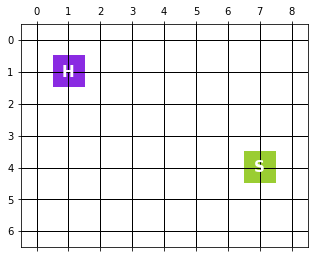

In [88]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
azkaban_map = create_map(map_size, init_pos, goal_pos)
env = AzkabanEnviroment(azkaban_map, init_pos, goal_pos)
env.render()

In [89]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

print((action_space_size, state_space_size))

(8, 63)


down_right


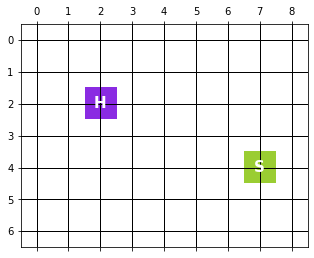

In [90]:
action = env.action_space.sample()
state = env.reset()
new_state, reward, done = env.step(action)
print(env.get_actions(action))
env.render()

In [91]:
def policies_matrix(q_table, map):
    state_best_actions =[]
    arrow_matrix = []
    for i in range(q_table.shape[0]):
        max_pos = np.argmax(q_table[i])
        state_best_actions.append(max_pos)
    arrow_matrix = np.array(state_best_actions).reshape(map.shape[0], map.shape[1])
    return arrow_matrix

In [92]:
def show_optimal_policy(map):
    row_labels, col_labels = range(map.shape[0]), range(map.shape[1])
    cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
    norm = Normalize(vmin=0, vmax=2)
    plt.matshow(map, cmap=cmap, norm=norm)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    plt.grid(color='k', linewidth=1)
    init = np.where(map == 1)
    plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', backgroundcolor='blueviolet', fontsize=20)
    goal = np.where(map == 2)
    plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', backgroundcolor='yellowgreen', fontsize=20)

    arrows = ['\u2191', '\u2193', '\u2190', '\u2192', '\u2197', '\u2196', '\u2199', '\u2198']
    for i, row in enumerate(map):
        for j, cell in enumerate(row):
            if cell == 0:
                plt.text(j, i, arrows[0], ha='center', va='center', color='black', weight='bold', backgroundcolor='lightblue', fontsize=20)
            elif cell == 1:
                plt.text(j, i, arrows[1], ha='center', va='center', color='black', weight='bold', backgroundcolor='lightblue', fontsize=20)
            elif cell == 2:
                plt.text(j, i, arrows[2], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 3:
                plt.text(j, i, arrows[3], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 4:
                plt.text(j, i, arrows[4], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 5:
                plt.text(j, i, arrows[5], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 6:
                plt.text(j, i, arrows[6], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 7:
                plt.text(j, i, arrows[7], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
    plt.show()

In [93]:
def plot_rewards_episodes(rewards_avg, num_episodes):
    x = [i for i in range(0, num_episodes)]
    y = np.mean(rewards_avg, axis=0)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.plot(x, y,'o')

In [94]:
def train_q_table(env, rewards_avg, iteration=100, learning_rate=0.95, discount_rate=0.95, num_episodes=6000, max_steps_per_episode=100):
    for it in range(iteration):
        clear_output(wait=True)
        print('average ', it)
        rewards_all_episodes=[]

        # exporation-exploitation trade-off params
        exploration_rate = 1
        max_exploration_rate = 1
        min_exploration_rate = 0.01
        exploration_decay_rate = 0.005

        # init q table in zeros
        q_table = np.zeros((state_space_size, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            state = env.reset()
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.rand()
                if exploration_rate_threshold <= exploration_rate:
                    action = np.random.randint(0, action_space_size) # Exploration time
                else:
                    action = np.argmax(q_table[state]) # Explotation time

                # Take action
                new_state, reward, done = env.step(action)

                # Update Q-table for Q(s,a)
                q_table[state, action] = (1-learning_rate) * q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state]))
                
                # transition next state
                state = new_state
                rewards_current_episode += reward

                if done == True: 
                    break


            # Exploration rate decay
            exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * (np.exp(-exploration_decay_rate * episode)) #your code here
            #env.render()
            rewards_all_episodes.append(rewards_current_episode)

        rewards_avg.append(rewards_all_episodes)
    return q_table

# Run 1

average  99
Harry init action: down_left
Harry end action: up


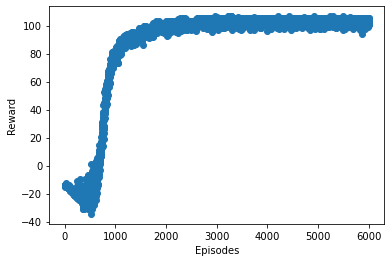

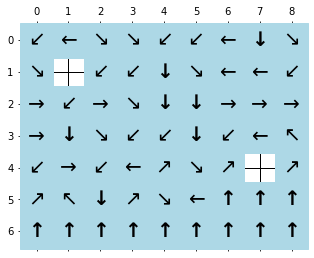

In [95]:
# Applying Q-learning
walk_reward_1 = -1
fall_reward_1 = -10
goal_reward_1 = 150

env.reset()
env.set_rewards(walk_reward_1 , fall_reward_1, goal_reward_1)

# Initialize parameters
rewards_avg_1 = []
iteration_1 = 100 # value function
learning_rate_1 = 0.1
discount_rate_1 = 0.95
num_episodes_1 = 6000 #15000
max_steps_per_episode_1 = 100 #100

#train Q-table
q_table_1 = train_q_table(env, rewards_avg_1, iteration_1, learning_rate_1, discount_rate_1, num_episodes_1, max_steps_per_episode_1)
plot_rewards_episodes(rewards_avg_1, num_episodes_1)

# Optimal policy
arrow_matrix = policies_matrix(q_table_1, azkaban_map)
print('Harry init action:', actions[arrow_matrix[1][1]])
print('Harry end action:', actions[arrow_matrix[4][7]])
arrow_matrix[1][1] = -2
arrow_matrix[4][7] = -3
show_optimal_policy(arrow_matrix)

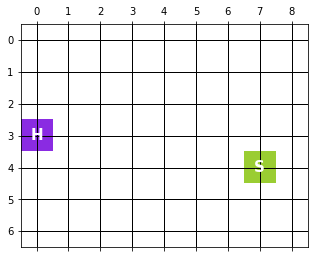

In [96]:
env.render()